**Imports**

In [1]:
import os
import gdal
import numpy as np
import batch_feeder as bf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Sequential
import support_functions as sf
import matplotlib.pyplot as plt

cwd = os.getcwd()

**File lists and feature types definition**

In [2]:
## input file list
file_list = ["SAR_5m_amplitude_vv.tif",
             "SAR_5m_amplitude_vh.tif",
             "SAR_5m_intensity_vv.tif",
             "SAR_5m_intensity_vh.tif",
             "sentinel_B02_5m.tif",
             "sentinel_B03_5m.tif",
             "sentinel_B04_5m.tif",
             "sentinel_B08_5m.tif",
             "probe_aggregated_trajectory_count.tif",
             "probe_aggregated_speed_avg.tif",
             "_bejing_full_projected_labels.tif"]

## raster values definition list
file_list_types = ["sar",
                   "sar",
                   "sar",
                   "sar",
                   "MSI",
                   "MSI",
                   "MSI",
                   "MSI",
                   "count",
                   "average_speed",
                   "label"]

**Raster read function and pre-processing**
* Replace no data with 0
* Replace nan values with 0
* Replace subzero values with 0 (check further for GPS data preperation stage related errors)
* Remove outliers from MSI data (10000 as upper bound as per specs)
* Remove outliers from SAR data (2<sup>16</sup> as upper boundsd as per specs)
* Scale MSI and SAR DNs with 0 to upper bound.

In [18]:
## raster reader function TODO: add coordinate system getters
def read_raster(file_path, image_type):
    print(file_path)
    raster_file = gdal.Open(file_path)
    raster_np = raster_file.GetRasterBand(1).ReadAsArray()
    raster_geo = raster_file.GetGeoTransform()

    # close the raster file to free the memory
    raster_file = None
        
    # replace no data values with zero
    raster_np[raster_np == -9999.0] = 0.0
    
    # values before pre-processing
    print("Before pre-processing:")
    print("Mean: {0:2.2f}, Median {1:2.2f}, Std: {2:2.2f}, Min: {3:2.2f}, Max: {4:2.2f}".format(
        np.mean(raster_np), np.median(raster_np), np.std(raster_np), np.min(raster_np), np.max(raster_np)))

    # process input values
    # replace NaNs with zero
    raster_np[np.isnan(raster_np)] = 0.0
    
    # replace subzero values with zero
    raster_np[raster_np < 0] = 0.0

    # convert data type to float
    raster_np = raster_np.astype(np.float64)

    #replace outliers of SAR product
    if (image_type == 'sar'):
        raster_np[raster_np > 65536.0] = 65536.0
        raster_np = raster_np / 65536.00

    # replace outliers of MSI product
    if(image_type == 'MSI'):
        raster_np[raster_np > 10000.0] = 10000.0
        raster_np = raster_np / 10000.0
        
    # remove inconsistend average speed values
    if(image_type == 'average_speed'):
        raster_np[raster_np > 180] = 180.0 
    
    # min-max normalisation of rest of the layers
    if(image_type != 'sar' and image_type != 'MSI' and image_type != 'labels'):
        raster_np = (raster_np - np.min(raster_np)) / (np.max(raster_np) - np.min(raster_np))

    # return raster as numpy array and geo transformation parameters
    return raster_np, raster_geo


**Read raster files**

Reading file: SAR_5m_amplitude_vv.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/SAR_5m_amplitude_vv.tif
Before pre-processing:
Mean: 301.34, Median 224.28, Std: 325.74, Min: 0.00, Max: 55611.90
After pre-processing:
Mean: 0.00, Median 0.00, Std: 0.00, Min: 0.00, Max: 0.85


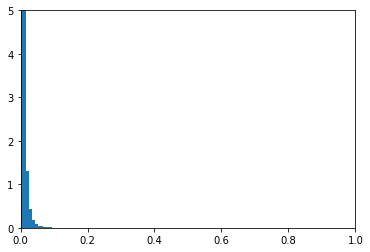

Reading file: SAR_5m_amplitude_vh.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/SAR_5m_amplitude_vh.tif
Before pre-processing:
Mean: 117.92, Median 99.60, Std: 96.23, Min: 0.00, Max: 26977.45
After pre-processing:
Mean: 0.00, Median 0.00, Std: 0.00, Min: 0.00, Max: 0.41


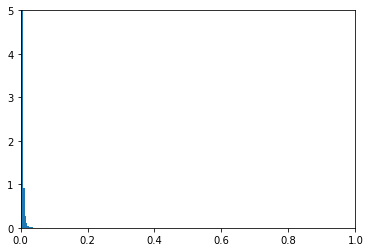

Reading file: SAR_5m_intensity_vv.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/SAR_5m_intensity_vv.tif
Before pre-processing:
Mean: 207363.06, Median 51598.26, Std: 3069233.25, Min: 0.00, Max: 3124039936.00
After pre-processing:
Mean: 0.70, Median 0.79, Std: 0.32, Min: 0.00, Max: 1.00


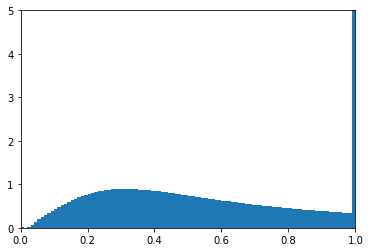

Reading file: SAR_5m_intensity_vh.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/SAR_5m_intensity_vh.tif
Before pre-processing:
Mean: 24110.28, Median 10135.73, Std: 505362.50, Min: 0.00, Max: 735086848.00
After pre-processing:
Mean: 0.24, Median 0.15, Std: 0.24, Min: 0.00, Max: 1.00


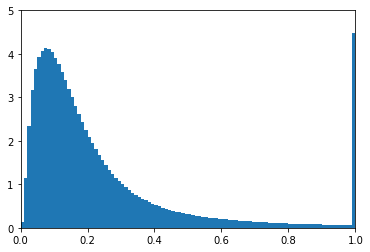

Reading file: sentinel_B02_5m.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/sentinel_B02_5m.tif
Before pre-processing:
Mean: 1561.77, Median 1536.00, Std: 242.78, Min: 0.00, Max: 19520.00
After pre-processing:
Mean: 0.16, Median 0.15, Std: 0.02, Min: 0.00, Max: 1.00


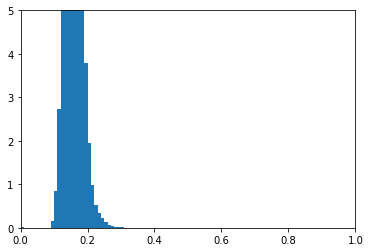

Reading file: sentinel_B03_5m.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/sentinel_B03_5m.tif
Before pre-processing:
Mean: 1667.46, Median 1650.00, Std: 255.71, Min: 0.00, Max: 18272.00
After pre-processing:
Mean: 0.17, Median 0.17, Std: 0.03, Min: 0.00, Max: 1.00


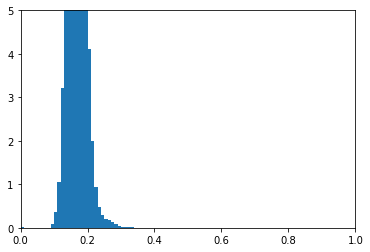

Reading file: sentinel_B04_5m.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/sentinel_B04_5m.tif
Before pre-processing:
Mean: 1730.96, Median 1722.00, Std: 299.50, Min: 0.00, Max: 17296.00
After pre-processing:
Mean: 0.17, Median 0.17, Std: 0.03, Min: 0.00, Max: 1.00


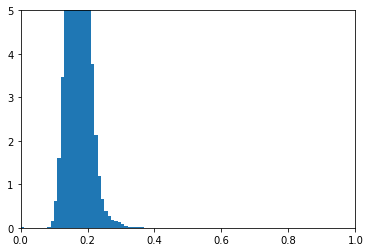

Reading file: sentinel_B08_5m.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/sentinel_B08_5m.tif
Before pre-processing:
Mean: 2069.14, Median 2084.00, Std: 402.26, Min: 0.00, Max: 16480.00
After pre-processing:
Mean: 0.21, Median 0.21, Std: 0.04, Min: 0.00, Max: 1.00


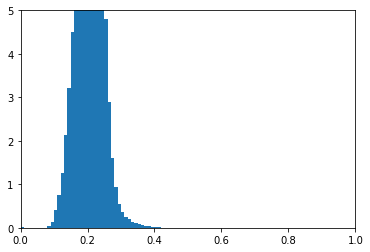

Reading file: probe_aggregated_trajectory_count.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/probe_aggregated_trajectory_count.tif
Before pre-processing:
Mean: 0.30, Median 0.00, Std: 4.91, Min: 0.00, Max: 5244.00
After pre-processing:
Mean: 0.00, Median 0.00, Std: 0.00, Min: 0.00, Max: 1.00


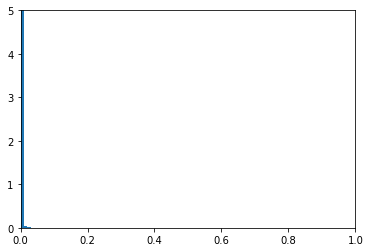

Reading file: probe_aggregated_speed_avg.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/probe_aggregated_speed_avg.tif
Before pre-processing:
Mean: 2.64, Median 0.00, Std: 1203.95, Min: -511.57, Max: 1551774.75
After pre-processing:
Mean: 0.00, Median 0.00, Std: 0.00, Min: 0.00, Max: 1.00


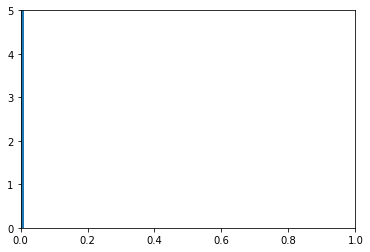

Reading file: _bejing_full_projected_labels.tif
/home/nagellette-ws/negengec_code/pub1_rnn_model/data/_bejing_full_projected_labels.tif
Before pre-processing:
Mean: 5.32, Median 0.00, Std: 36.46, Min: 0.00, Max: 255.00
After pre-processing:
Mean: 0.02, Median 0.00, Std: 0.14, Min: 0.00, Max: 1.00


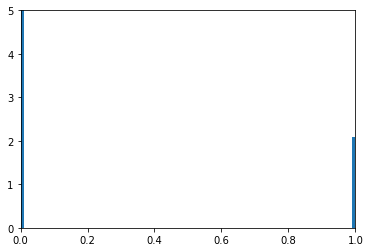

In [19]:
## empty list for
rasters_np = []
rasters_geo = []

## iterate over file list and read the rasterfiles
for index, file in enumerate(file_list):
    print("Reading file: " + file)
    raster_np, raster_geo = read_raster(cwd + "/data/" + file, file_list_types[index])
    print("After pre-processing:")
    print("Mean: {0:2.2f}, Median {1:2.2f}, Std: {2:2.2f}, Min: {3:2.2f}, Max: {4:2.2f}".format(
        np.mean(raster_np), np.median(raster_np), np.std(raster_np), np.min(raster_np), np.max(raster_np)))
    
    x = raster_np.flatten()
    plt.hist(x, density=True, bins=100)
    ax = plt.gca()
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 5]) ## ignore some values to keep some visible
    plt.show()

    rasters_geo.append(raster_geo)
    rasters_np.append(raster_np)